## Augmentation 적용

```
pip install tensorflow_datasets
```

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

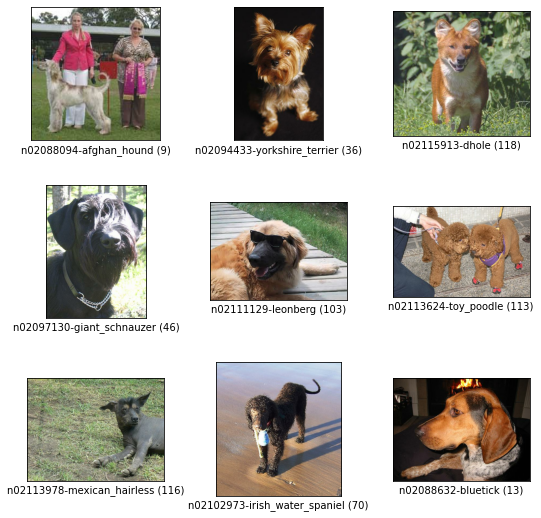

In [5]:
fig = tfds.show_examples(ds_train,ds_info)

### 텐서플로우 Random Augmentation API 사용하기
random_brightness()    
random_contrast()    
random_crop()    
random_flip_left_right()    
random_flip_up_down()    
random_hue()     
random_jpeg_quality()    
random_saturation()     

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [8]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

## 비교실험하기

### Augmentation 진행한 모델 VS 진행안한 모델의 성능차이는!?



### Resnet 불러오기

In [11]:
## 그냥 Resnet50
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [12]:
## Augmentation 적용시킬 Resnet50
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 텐서플로우 데이터셋 불러오기, Augmentation 된것과 안된것 모두 불러오기

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [ ]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

## 훈련과정 시각화

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

NameError: name 'history_resnet50_no_aug' is not defined

In [21]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

NameError: name 'history_resnet50_no_aug' is not defined

## Augmentation 심화기법
### 1) Cutmix Augmentation
![img](im_cv4_1.png)

### 1) 이미지 섞기

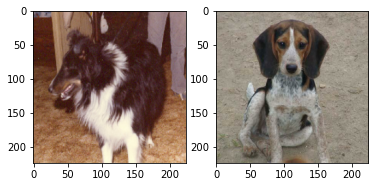

In [14]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [15]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(82, shape=(), dtype=int32) tf.Tensor(28, shape=(), dtype=int32) tf.Tensor(220, shape=(), dtype=int32) tf.Tensor(166, shape=(), dtype=int32)


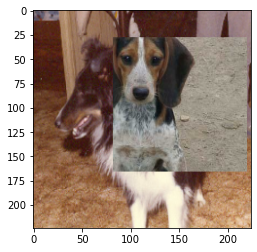

In [16]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 2) 라벨 섞기

In [17]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.37954402, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [18]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

### 2. Mixip Augmentation 

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.37954402 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.620456   0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

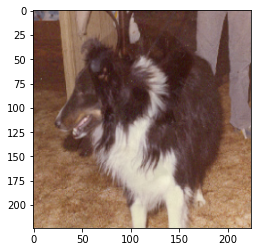

In [19]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [20]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 프로젝트 : CutMix 또는 Mixup 비교실험

### 1. Augmentation을 적용한 데이터셋 만들기

### 2. 모델 만들기
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화

### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석